In [1]:
%%capture
!pip install matplotlib transformers datasets accelerate sentence-transformers

In [2]:
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def get_secret(key_name):
    # CHECK: Are we running in Google Colab?
    in_colab = 'google.colab' in sys.modules

    if in_colab:
        # OPTION A: Try Native Colab Secrets (works in Browser, sometimes fails in VS Code extension)
        try:
            from google.colab import userdata
            
            return userdata.get(key_name)
        
        except (ImportError, Exception):
            # OPTION B: Fallback to Manual Input or Drive if native secrets fail
            print(f"⚠️ Colab Secret '{key_name}' not found. Please set it manually.")
            from getpass import getpass
            
            return getpass(f"Enter value for {key_name}: ")
    else:
        # OPTION C: We are running locally (Mac M1)
        from dotenv import load_dotenv
        load_dotenv() # Load .env from local folder
        
        return os.getenv(key_name)

## CLIP


In [4]:
from urllib.request import urlopen
from PIL import Image

puppy_path = 'https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/chapter09/images/puppy.png'
image = Image.open(urlopen(puppy_path)).convert('RGB')
caption = 'a puppy playing in the snow'

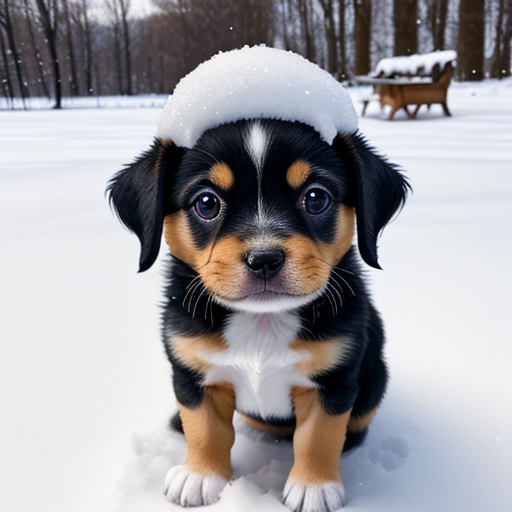

In [5]:
image

## Embeddings


In [6]:
from transformers import CLIPTokenizerFast, CLIPProcessor, CLIPModel

model_id = 'openai/clip-vit-base-patch32'

clip_tokenizer = CLIPTokenizerFast.from_pretrained(model_id)

clip_processor = CLIPProcessor.from_pretrained(model_id)

model = CLIPModel.from_pretrained(model_id)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [7]:
inputs = clip_tokenizer(caption, return_tensors='pt')
inputs

{'input_ids': tensor([[49406,   320,  6829,  1629,   530,   518,  2583, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}

In [8]:
clip_tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

['<|startoftext|>',
 'a</w>',
 'puppy</w>',
 'playing</w>',
 'in</w>',
 'the</w>',
 'snow</w>',
 '<|endoftext|>']

In [9]:
text_embedding = model.get_text_features(**inputs)
text_embedding.shape

torch.Size([1, 512])

In [10]:
processed_image = clip_processor(text=None, images=image, return_tensors='pt')['pixel_values']

processed_image.shape

torch.Size([1, 3, 224, 224])

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

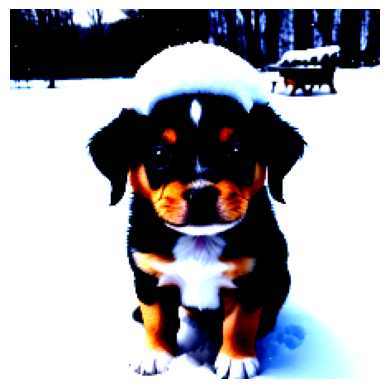

In [11]:
img = processed_image.squeeze(0)
img = img.permute(*torch.arange(img.ndim - 1, -1, -1))
img = np.einsum('ijk->jik', img)

plt.imshow(img)
plt.axis('off')

In [12]:
# Creating the image embeddings
image_embedding = model.get_image_features(processed_image)
image_embedding.shape

torch.Size([1, 512])

In [13]:
# Normalize the embeddings
text_embedding /= text_embedding.norm(dim=-1, keepdim=True)
image_embedding /= image_embedding.norm(dim=-1, keepdim=True)

In [14]:
# Calculate embedding simimlarity
text_embedding = text_embedding.detach().cpu().numpy()
image_embedding = image_embedding.detach().cpu().numpy()
score = text_embedding @ image_embedding.T
score

array([[0.33149636]], dtype=float32)

### More images


In [15]:
cat_path = "https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/chapter09/images/cat.png"
car_path = "https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/chapter09/images/car.png"

paths = [ puppy_path, cat_path, car_path ]
images = [Image.open(urlopen(path)).convert('RGB') for path in paths]
captions = [
    'a puppy playing in the snow',
    'a pixelated image of a cute cat',
    'A supercar on the road \n with the sunset in the background'
]

# Embed all images
image_embeddings = []

for image in images:
    image_processed = clip_processor(images=image, return_tensors='pt')['pixel_values']
    image_embedding = model.get_image_features(image_processed).detach().cpu().numpy()[0]
    image_embeddings.append(image_embedding)
    
image_embeddings = np.array(image_embeddings)

# Embed all captions
text_embeddings = []

for caption in captions:
    inputs = clip_tokenizer(caption, return_tensors='pt')
    text_emb = model.get_text_features(**inputs).detach().cpu().numpy()[0]
    text_embeddings.append(text_emb)

text_embeddings = np.array(text_embeddings)

In [16]:
# Calculate cosine similarity between images and captions
from sklearn.metrics.pairwise import cosine_similarity

sim_matrix = cosine_similarity(image_embeddings, text_embeddings)

Text(0.5, 1.0, 'Similarity matrix')

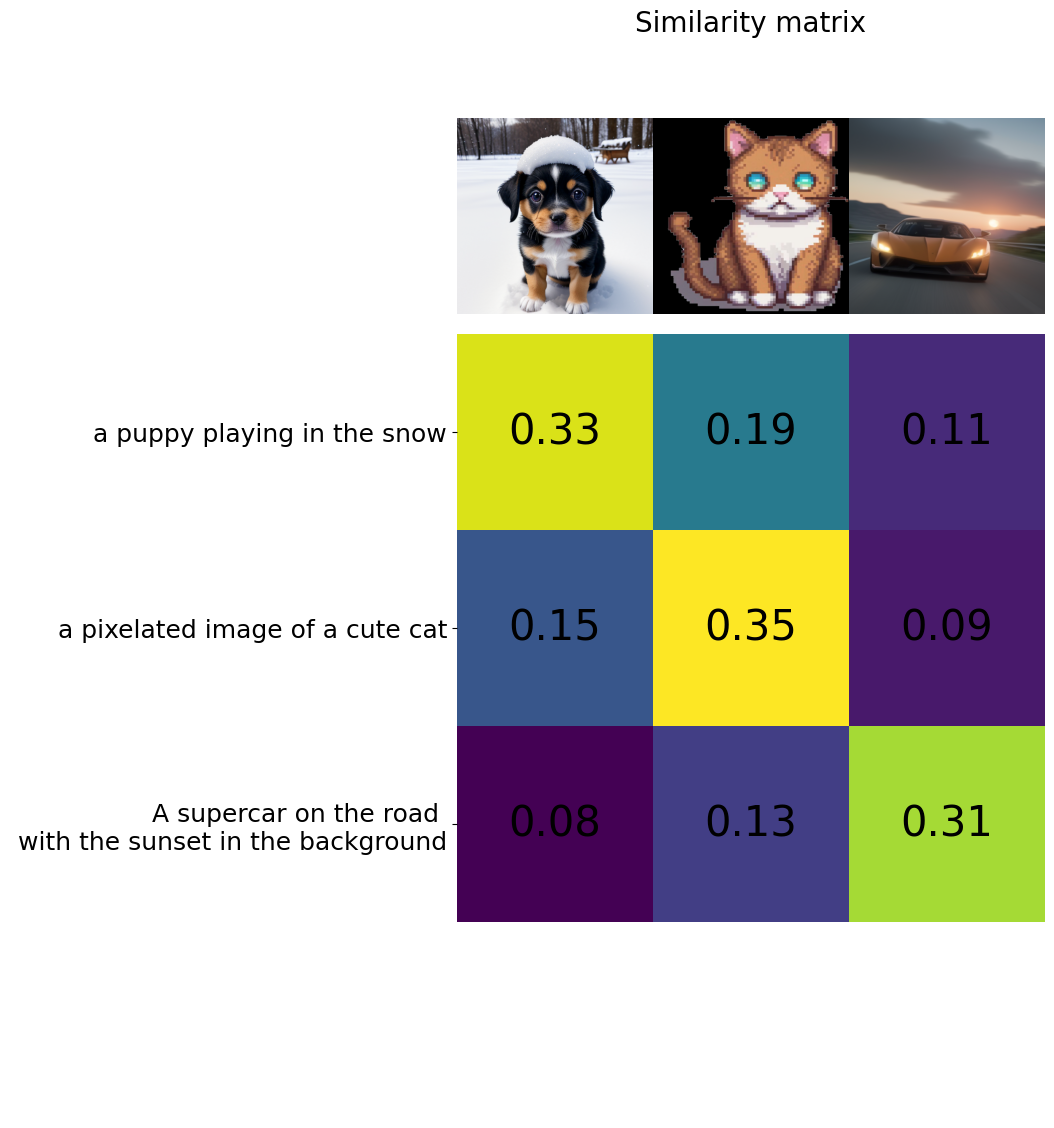

In [17]:
plt.figure(figsize=(20, 14))
plt.imshow(sim_matrix, cmap='viridis')

# adjust ticks with correct labels
plt.yticks(range(len(captions)), captions, fontsize=18)
plt.xticks([])

for i, image in enumerate(images):
    plt.imshow(image, extent=(i-0.5, i+0.5, -1.6, -0.6), origin='lower')
    
for x in range(sim_matrix.shape[1]):
    for y in range(sim_matrix.shape[0]):
        plt.text(x, y, f'{sim_matrix[y, x]:.2f}', ha='center', va='center', size=30)
        
# Remove unnecessary spines
for side in ['left', 'top', 'right', 'bottom']:
    plt.gca().spines[side].set_visible(False)
    
plt.xlim([-0.5, len(captions) - 0.5])
plt.ylim([len(captions) + 0.5, -2])
plt.title('Similarity matrix', size=20)

### SBERT


In [18]:
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer('clip-Vit-B-32')

image_embeddings = model.encode(images)

text_embeddings = model.encode(captions)

sim_matrix = util.cos_sim(image_embeddings, text_embeddings)
print(sim_matrix)

tensor([[0.3315, 0.1863, 0.1084],
        [0.1488, 0.3463, 0.0947],
        [0.0762, 0.1260, 0.3098]])


### BLIP-2


In [ ]:
from transformers import Blip2Processor, Blip2ForConditionalGeneration

# Load processor and main model
blip_processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")

model = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-opt-2.7b",
    torch_dtype=torch.float16,
    device_map='auto'
)

`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [20]:
torch.cuda.is_available()

True

In [21]:
# Critical fix
if model.config.image_token_index is None:
    model.config.image_token_index = (
        blip_processor.tokenizer.convert_tokens_to_ids('<images>')
    )

### Preprocessing images


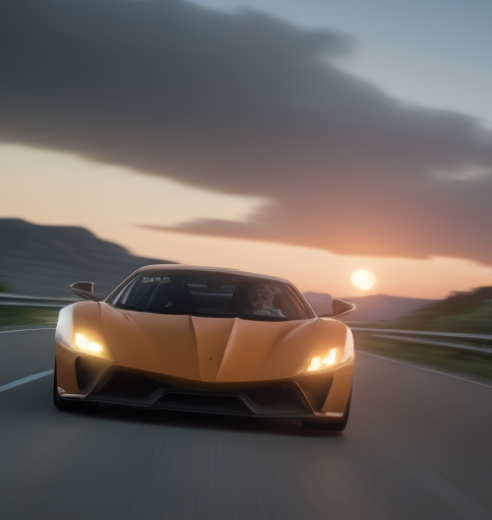

In [22]:
# Load image of the car
car_path = "https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/chapter09/images/car.png"
image = Image.open(urlopen(car_path)).convert('RGB')
image

In [24]:
# Preprocess the image
inputs = blip_processor(image, return_tensors='pt').to(model.device, torch.float16)
inputs['pixel_values'].shape

torch.Size([1, 3, 224, 224])

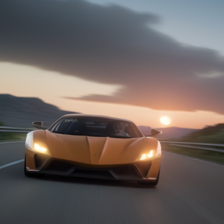

In [25]:
from sklearn.preprocessing import MinMaxScaler

image_inputs = inputs['pixel_values'][0].detach().cpu().numpy()
image_inputs = np.einsum('ijk->kji', image_inputs)
image_inputs = np.einsum('ijk->jik', image_inputs)

# Scale image inputs to 0-225 to represent RGB values
scaler = MinMaxScaler(feature_range=(0, 255))
image_inputs = scaler.fit_transform(image_inputs.reshape(-1, image_inputs.shape[-1])).reshape(image_inputs.shape)
image_inputs = np.array(image_inputs, dtype=np.uint8)

# Convert numpy array to image
Image.fromarray(image_inputs)

### Preprocessing text


In [26]:
blip_processor.tokenizer

GPT2TokenizerFast(name_or_path='Salesforce/blip2-opt-2.7b', vocab_size=50265, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '</s>', 'eos_token': '</s>', 'unk_token': '</s>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	50265: AddedToken("<image>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [27]:
# Preprocess the text
text = 'Her vocalization was remarkably melodic'
token_ids = blip_processor(image, text=text, return_tensors='pt')
token_ids = token_ids.to(model.device, torch.float16)['input_ids'][0]

tokens = blip_processor.tokenizer.convert_ids_to_tokens(token_ids)
tokens

['<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '</s>',
 'Her',
 'Ġvocal',
 'ization',
 'Ġwas',
 'Ġremarkably',
 'Ġmel',
 'odic']

In [28]:
# Replace the space token with an underscore
tokens = [token.replace('Ġ', '') for token in tokens]
tokens

['<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '</s>',
 'Her',
 'vocal',
 'ization',
 'was',
 'remarkably',
 'mel',
 'odic']

## Use case 1: Image captioning


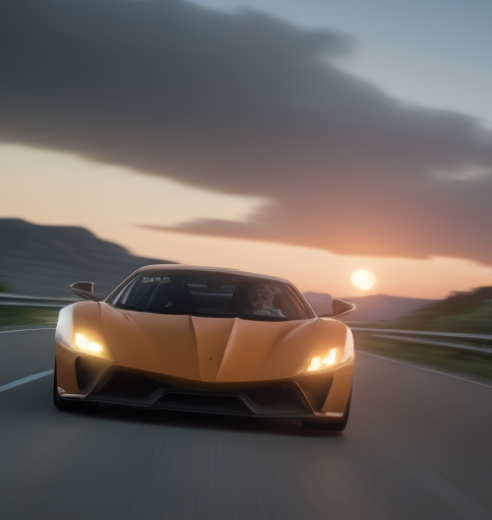

In [29]:
image = Image.open(urlopen(car_path)).convert('RGB')

inputs = blip_processor(image, return_tensors='pt').to(model.device, torch.float16)
image

In [30]:
print("image_token_index:", model.config.image_token_index)
print("num_query_tokens:", model.config.num_query_tokens)
print("<image> token id:", blip_processor.tokenizer.convert_tokens_to_ids("<image>"))


image_token_index: 50265
num_query_tokens: 32
<image> token id: 50265


In [31]:
# Generate image ids to be passed to the decoder (LLM)
generated_ids = model.generate(**inputs, max_new_tokens=20)

# Generate text from the image ids
generated_text = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)
generated_text = generated_text[0].strip()
generated_text

'an orange supercar driving on the road at sunset'

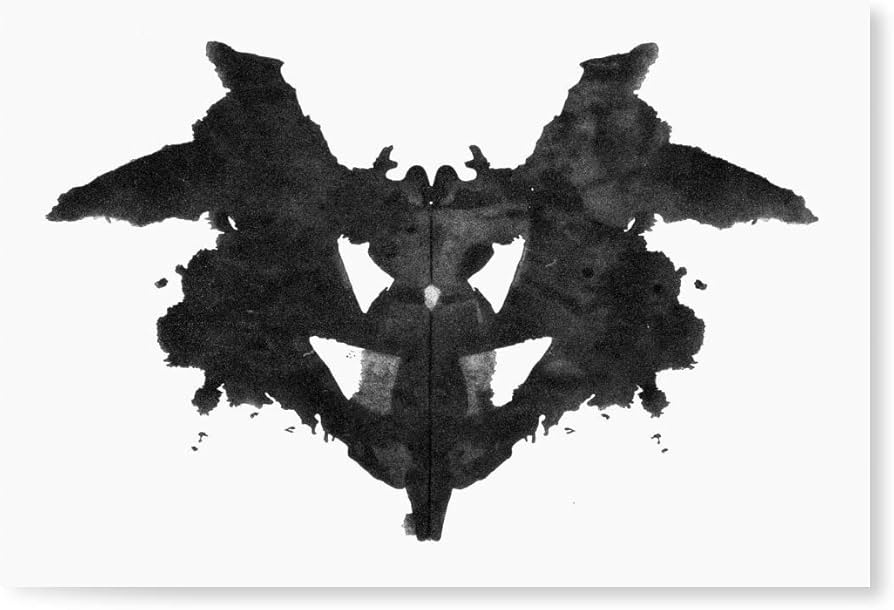

In [34]:
url = "https://m.media-amazon.com/images/I/61xiu4jhOoL._AC_UF894,1000_QL80_.jpg"
image = Image.open(urlopen(url)).convert('RGB')
image

In [35]:
# Load rorschach image
image = Image.open(urlopen(url)).convert('RGB')

# Generate caption
inputs = blip_processor(image, return_tensors='pt').to(model.device, torch.float16)
generated_ids = model.generate(**inputs, max_new_tokens=20)
generated_text = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)
generated_text = generated_text[0].strip()
generated_text

'a black and white print of a bat with wings'

### Use case 2: Visual question answering


In [36]:
image = Image.open(urlopen(car_path)).convert('RGB')

prompt = 'Question: Write down what you see in this picture. Answer:'

inputs = blip_processor(image, text=prompt, return_tensors='pt').to(model.device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=30)
generated_text = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)
generated_text = generated_text[0].strip()
generated_text

'Question: Write down what you see in this picture. Answer: A sports car driving on the road at sunset'

In [37]:
prompt = 'Question: Write down what you see in this picture. '
prompt = prompt + 'Answer: A sports car driving on the road at sunset. '
prompt = prompt + 'Question: What would it cost me to drive that car? '
prompt = prompt + 'Answer:'

inputs = blip_processor(image, text=prompt, return_tensors='pt').to(model.device, torch.float16)
generated_ids = model.generate(**inputs, max_new_tokens=30)
generated_text = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)
generated_text = generated_text[0].strip()
generated_text

'Question: Write down what you see in this picture. Answer: A sports car driving on the road at sunset. Question: What would it cost me to drive that car? Answer: $1,000,000'

In [55]:
from IPython.display import HTML, display
import ipywidgets as widgets

memory = []
output = widgets.Output()
display(output)

def text_eventhandler(change):
    question = change['new']
    if not question.strip():
        return
    
    change['owner'].value = ''  # clear input box
    
    # Build prompt
    if not memory:
        prompt = f"Question: {question} Answer:"
    else:
        history = " ".join(
            f"Question: {q} Answer: {a}."
            for q, a in memory
        )
        prompt = history + f" Question: {question} Answer:"
    
    # BLIP-2 inference
    inputs = blip_processor(
        images=image,
        text=prompt,
        return_tensors="pt"
    ).to(model.device)
    
    generated_ids = model.generate(
        **inputs,
        max_new_tokens=100
    )
    
    generated_text = blip_processor.batch_decode(
        generated_ids,
        skip_special_tokens=True
    )[0]
    
    generated_text = generated_text.split("Question")[0].strip()
    memory.append((question, generated_text))
    
    # Display output
    with output:
        display(HTML(f"<b>USER:</b> {question}"))
        display(HTML(f"<b>BLIP-2:</b> {generated_text}"))
        display(HTML("<br>"))

in_text = widgets.Text(continuous_update=False)
in_text.observe(text_eventhandler, names="value")
display(in_text)


Output()

Text(value='', continuous_update=False)

In [56]:
print(type(output))
print(type(in_text))

<class 'ipywidgets.widgets.widget_output.Output'>
<class 'ipywidgets.widgets.widget_string.Text'>


In [57]:
display(HTML("<b>TEST OUTPUT</b>"))

In [58]:
display(output)

Output()

In [59]:
with output:
    print("Widget output works")